In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-04-24 18:15:16.397784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-24 18:15:17.759839: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-24 18:15:17.763248: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-24 18:15:17.788800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 18:15:17.788892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.83GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-04-24 18:15:17.788905: I tensorflow/stream_executor/platform/def

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

from src.visualization.plotting_utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


from src.metadata_processing.process_sounds_metadata import generate_sounds_metadata 
from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from src.deep_learning.soundtype_classifier.classify_sounds_metadata import classify_sounds_metadata

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

dates = 'all'
colonies = ['arryn', 'targaryen', 'martell', 'lannister', 'tyrell']
experiments = 'all'
stages = ['traced and checked', 'labeled and checked', 'split and checked']
stages = 'all'
classes_to_drop = ['weirdo', 'badsplit', 'noise', 'sound']

path_to_models = PATH_TO_PROJECT + 'models/classifier/networks/'
path_to_datasets = PATH_TO_PROJECT + 'models/classifier/datasets/'
all_models = os.listdir(path_to_datasets)

In [13]:
model_name = all_models[0]
print(model_name)

nmr_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000


In [14]:
# Load labels from the model and sounds metadata to test the model on
with open(path_to_datasets + model_name + '/params_dict.pickle', 'rb') as f:
    all_params_dict = pickle.load(f)
all_classes = np.load(path_to_datasets + model_name + '/all_classes.npy')
recs_metadata, recs_dict = load_recordings_metadata(path_to_recordings_metadata, recordings_metadata_name,
                                                    dates, colonies, experiments, stages)
sounds_metadata = generate_sounds_metadata(recs_metadata, classes_to_drop, {}, 
                                           all_params_dict['sounds_metadata']['min_sound_length'], 
                                           all_params_dict['sounds_metadata']['max_sound_length'],
                                           sr=all_params_dict['sr'],  print_counts=False)
print(sounds_metadata.shape)
sounds_metadata.head()

Using 821 recordings
(15340, 8)


/home/gr1/Projects/naked-mole-rats/src/metadata_processing/process_sounds_metadata.py:36: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata = pd.concat(sounds_metadata, 0).reset_index(drop=True)


,s,e,cl,rec,colony,ratids,date,experiment
0,15.060208,15.271087,loudchirp,martell_08-11-19_9438_0000035.npy,martell,9438,08-11-19,single rat softchirps
1,15.867553,16.095966,loudchirp,martell_08-11-19_9438_0000035.npy,martell,9438,08-11-19,single rat softchirps
2,16.373889,16.617111,softchirp,martell_08-11-19_9438_0000035.npy,martell,9438,08-11-19,single rat softchirps
3,17.295061,17.473719,softchirp,martell_08-11-19_9438_0000035.npy,martell,9438,08-11-19,single rat softchirps
4,18.455880,18.668725,softchirp,martell_08-11-19_9438_0000035.npy,martell,9438,08-11-19,single rat softchirps


In [15]:
mask_class_is_known = sounds_metadata['cl'].isin(all_classes)
print(mask_class_is_known.mean())
sounds_metadata_filtered = sounds_metadata[mask_class_is_known].reset_index(drop=True)


0.9245110821382008


In [11]:
# all_params_dict['features']['frequency_threshold'] = 300

In [16]:
model = tf.keras.models.load_model(path_to_models + model_name)
predicted_labels, melspecs = classify_sounds_metadata(model, sounds_metadata_filtered, recs_dict, all_classes,
                                           all_params_dict, return_grouped=False)
predicted_labels = np.array(predicted_labels)
true_labels = sounds_metadata_filtered['cl']

/home/gr1/Projects/naked-mole-rats/src/deep_learning/soundtype_classifier/classify_sounds_metadata.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for sound in sounds_npy_aug])
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_wave.py:31: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(sr, n_fft=nfft, n_mels=n_mel)
2022-04-24 18:19:27.586752: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 290447360 exceeds 10% of free system memory.
2022-04-24 18:19:28.584276: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Up

2022-04-24 18:19:32.665782: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:32.832600: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:33.000225: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:33.170762: W tensorflow/stream_executor/gpu/

2022-04-24 18:19:37.386967: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:37.552359: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:37.717493: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:37.880800: W tensorflow/stream_executor/gpu/

2022-04-24 18:19:42.051258: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:42.216180: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:42.386103: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:42.550082: W tensorflow/stream_executor/gpu/

2022-04-24 18:19:46.776473: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:46.941436: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:47.109480: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 18:19:47.274216: W tensorflow/stream_executor/gpu/

In [19]:
sounds_metadata_filtered['colony'] = 'berlin'

Colony: berlin
Accuracy: 0.83


/home/gr1/Projects/naked-mole-rats/src/visualization/plotting_utils.py:34: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]


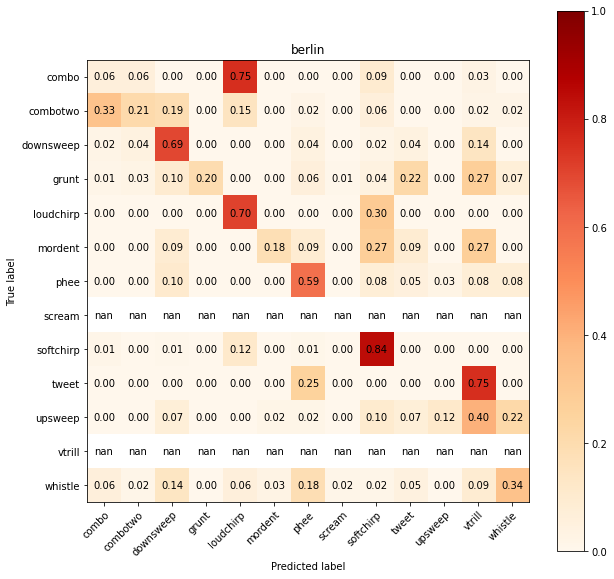

In [20]:
n_colonies = len(sounds_metadata_filtered['colony'].unique())

for colony in sounds_metadata_filtered['colony'].unique():
    colony_mask = sounds_metadata_filtered['colony'] == colony
    
    predicted_labels_colony = predicted_labels[colony_mask]
    true_labels_colony = true_labels[colony_mask]
    shared_classes = sorted(list(set(predicted_labels_colony) | set(true_labels_colony)))
    cm = confusion_matrix(true_labels_colony, predicted_labels_colony)
    print('Colony: %s' % colony)
    print('Accuracy: %.2f' % np.mean(predicted_labels_colony == true_labels_colony))

    
    fig = plot_confusion_matrix(cm, shared_classes,  
                                figsize = (9, 9), cmap = plt.cm.OrRd, normalize = True, clim = (0, 1))
    plt.title(colony)